In [48]:
!pip install pymysql
!pip install --upgrade sqlalchemy optuna
!pip install cryptography

## ⚙️ Import Libraries

In [49]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
from keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TerminateOnNaN
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

import optuna as op
from optuna.exceptions import OptunaError

from tqdm import tqdm

import pymysql
import sqlalchemy

np.random.seed(42)
tf.random.set_seed(42)
seed = 42

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


In [50]:
# Retrieve DB user and password from Kaggle secrets
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_db = user_secrets.get_secret("USER_DB")
pwd_db = user_secrets.get_secret("PWD_DB")

name = "MultipathUnet"

if name not in ["Unet", "UnetEnhanced", "MultipathUnet"]:
    raise Exception("Name is not valid")

In [51]:
data = np.load("/kaggle/input/an2dl-hw22024-2025/flippedx4_no_aliens.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

# Shuffle X_train and y_train while preserving correspondence
X_train, y_train = shuffle(X_train, y_train, random_state=seed)

X_test = data["test_set"]

num_classes = len(np.unique(y_train))

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")
print(f"Number of classes: {num_classes}")

Training X shape: (10020, 64, 128)
Training y shape: (10020, 64, 128)
Test X shape: (10022, 64, 128)
Number of classes: 5


In [52]:
# Compute pixel class distribution
unique_classes, class_pixel_counts = np.unique(y_train, return_counts=True)
total_pixels = sum(class_pixel_counts)

# Compute inverse frequency
class_weights = 1e6 / (class_pixel_counts + 1e-6)
class_weights[0] = 0
print(class_weights)

[0.         0.03593225 0.05233618 0.06629852 9.27196529]


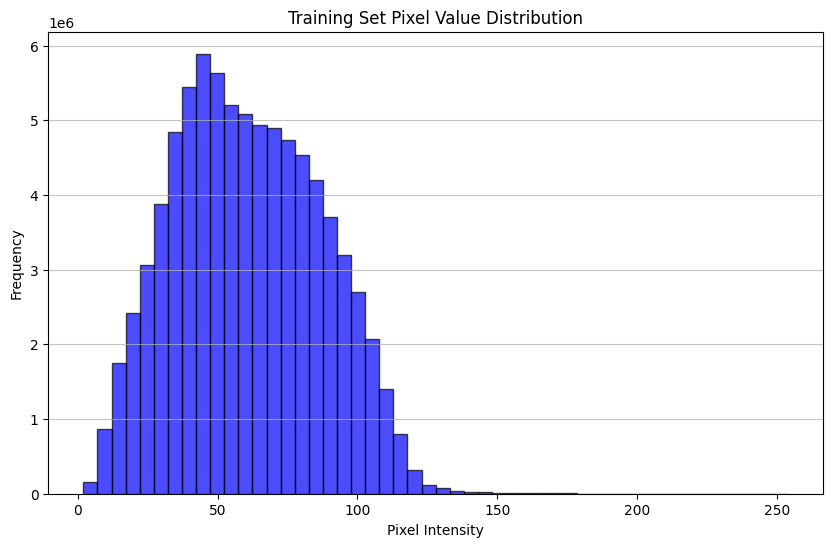

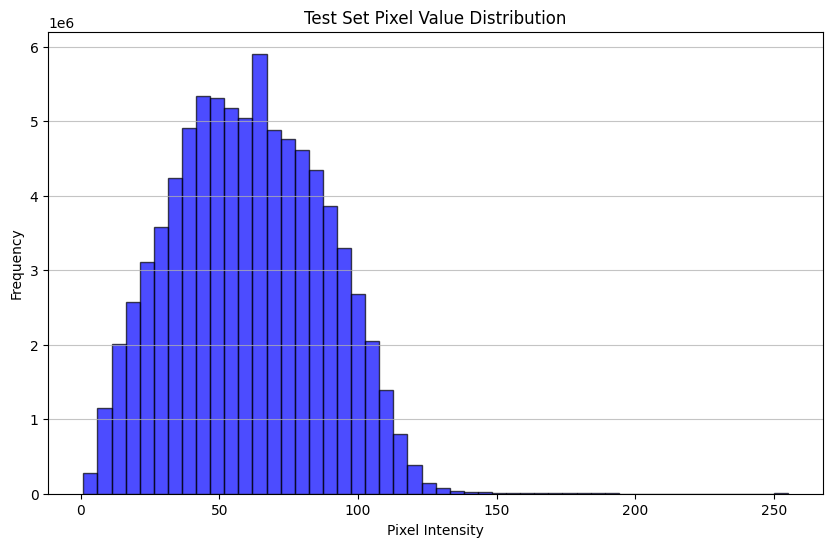

In [53]:
def plot_histogram(data, title="Pixel Value Distribution", bins=50):
    # Flatten the data to a 1D array for the histogram
    flat_data = data.flatten()
    
    plt.figure(figsize=(10, 6))
    plt.hist(flat_data, bins=bins, color='blue', edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Check that the used dataset didn't alter the intensity histogram wrt to the test set
plot_histogram(X_train, title="Training Set Pixel Value Distribution")
plot_histogram(X_test, title="Test Set Pixel Value Distribution")

In [54]:
# Compute pixel distribution for each class
unique_classes, class_pixel_counts = np.unique(y_train, return_counts=True)
total_pixels = sum(class_pixel_counts)

for cls, count in zip(unique_classes, class_pixel_counts):
    percentage = (count / total_pixels) * 100
    print(f"Class {cls}: {count} pixel ({percentage:.2f}%)")

Class 0.0: 19955304 pixel (24.31%)
Class 1.0: 27830152 pixel (33.90%)
Class 2.0: 19107240 pixel (23.28%)
Class 3.0: 15083292 pixel (18.38%)
Class 4.0: 107852 pixel (0.13%)


## 🛠️ Train and Save the Model

In [55]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x
    
def residual_block(input_tensor, filters, kernel_size=3, activation='relu', name=''):
    """Residual block with convolutional layers and a shortcut connection."""
    x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv1')(input_tensor)
    x = tfkl.BatchNormalization(name=name + 'bn1')(x)
    x = tfkl.Activation(activation, name=name + 'activation1')(x)

    x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv2')(x)
    x = tfkl.BatchNormalization(name=name + 'bn2')(x)

    shortcut = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + 'shortcut')(input_tensor)
    x = tfkl.Add(name=name + 'add')([x, shortcut])
    x = tfkl.Activation(activation, name=name + 'activation2')(x)

    return x

def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck with Residual Path
    bottleneck_main = unet_block(d3, 256, name='bottleneck_main')
    bottleneck_residual = residual_block(d3, 256, name='bottleneck_residual')
    bottleneck = tfkl.Add(name='bottleneck_add')([bottleneck_main, bottleneck_residual])

    # Upsampling path with transposed convolutions
    u1 = tfkl.Conv2DTranspose(128, kernel_size=2, strides=2, padding='same', name='up_conv1')(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_3])
    u1 = unet_block(u1, 128, name='up_block1_')

    u2 = tfkl.Conv2DTranspose(64, kernel_size=2, strides=2, padding='same', name='up_conv2')(u1)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 64, name='up_block2_')

    u3 = tfkl.Conv2DTranspose(32, kernel_size=2, strides=2, padding='same', name='up_conv3')(u2)
    u3 = tfkl.Add(name='skip_add')([u3, down_block_1])  # Use addition for lightweight feature merging
    u3 = unet_block(u3, 32, name='up_block3_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Enhanced_UNet')
    
    return model


In [56]:
def multi_scale_path(input_tensor, filters, name='multi_scale_'):
    """Auxiliary path with dilated convolutions for multi-scale feature extraction."""
    d1 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=1, padding='same', name=name + 'dilated1')(input_tensor)
    d1 = tfkl.BatchNormalization(name=name + 'bn1')(d1)
    d1 = tfkl.Activation('relu', name=name + 'activation1')(d1)

    d2 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=2, padding='same', name=name + 'dilated2')(input_tensor)
    d2 = tfkl.BatchNormalization(name=name + 'bn2')(d2)
    d2 = tfkl.Activation('relu', name=name + 'activation2')(d2)

    d3 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=4, padding='same', name=name + 'dilated4')(input_tensor)
    d3 = tfkl.BatchNormalization(name=name + 'bn3')(d3)
    d3 = tfkl.Activation('relu', name=name + 'activation3')(d3)

    # Combine multi-scale features
    multi_scale_output = tfkl.Add(name=name + 'add')([d1, d2, d3])
    return multi_scale_output

def global_context_path(input_tensor, filters, name='global_context_'):
    """Auxiliary path for global context using Global Average Pooling."""
    global_avg = tfkl.GlobalAveragePooling2D(name=name + 'gap')(input_tensor)
    global_avg = tfkl.Dense(filters, activation='relu', name=name + 'dense')(global_avg)
    global_avg = tfkl.Reshape((1, 1, filters), name=name + 'reshape')(global_avg)

    # Broadcast global context back to spatial dimensions
    global_context = tfkl.Conv2D(filters, kernel_size=1, activation='relu', padding='same', name=name + 'conv')(global_avg)
    global_context = tfkl.UpSampling2D(size=(input_tensor.shape[1], input_tensor.shape[2]), interpolation='bilinear', name=name + 'upsample')(global_context)

    return global_context

def get_enriched_unet_model(input_shape=(64, 128, 1), num_classes=5, seed=42):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck with Auxiliary Paths
    bottleneck_main = unet_block(d3, 256, name='bottleneck_main')
    bottleneck_residual = residual_block(d3, 32, name='bottleneck_residual')

    # Auxiliary Paths
    multi_scale_features = multi_scale_path(d3, 256, name='multi_scale_')
    global_context_features = global_context_path(d3, 32, name='global_context_')

    # Merge bottleneck and auxiliary features
    bottleneck = tfkl.Concatenate(name='bottleneck_add')([
        bottleneck_main,
        bottleneck_residual,
        multi_scale_features,
        global_context_features
    ])

        # Advanced Fusion Layer with Squeeze-and-Excitation Attention
    def squeeze_and_excite_block(input_tensor, reduction_ratio=16, name="se_block"):
        """Squeeze-and-Excitation Block for channel-wise attention."""
        channels = input_tensor.shape[-1]
        se = tfkl.GlobalAveragePooling2D(name=name + "_global_avg_pool")(input_tensor)
        se = tfkl.Dense(channels // reduction_ratio, activation='relu', name=name + "_dense1")(se)
        se = tfkl.Dense(channels, activation='sigmoid', name=name + "_dense2")(se)
        se = tfkl.Multiply(name=name + "_scale")([input_tensor, tfkl.Reshape((1, 1, channels))(se)])
        return se
    
    fusion_layer = tfkl.Conv2D(bottleneck.shape[-1], kernel_size=3, activation='relu', padding='same', name='fusion_conv')(bottleneck)
    fusion_layer = squeeze_and_excite_block(fusion_layer, reduction_ratio=16, name="fusion_se")
    fusion_layer = tfkl.Add(name='fusion_residual')([bottleneck, fusion_layer])  # Residual connection


    # Upsampling path
    u1 = tfkl.Conv2DTranspose(128, kernel_size=2, strides=2, padding='same', name='up_conv1')(fusion_layer)
    u1 = tfkl.Concatenate()([u1, down_block_3])
    u1 = unet_block(u1, 128, name='up_block1_')

    u2 = tfkl.Conv2DTranspose(64, kernel_size=2, strides=2, padding='same', name='up_conv2')(u1)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 64, name='up_block2_')

    u3 = tfkl.Conv2DTranspose(32, kernel_size=2, strides=2, padding='same', name='up_conv3')(u2)
    u3 = tfkl.Add(name='skip_add')([u3, down_block_1])  # Use addition for lightweight feature merging
    u3 = unet_block(u3, 32, name='up_block3_')
    
    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Enriched_UNet')

    return model

In [57]:
def get_unet():
    inputs = tfkl.Input(shape=input_shape)

    # Encoder: Downsampling
    c1 = tfkl.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    c1 = tfkl.Conv2D(32, (3, 3), activation="relu", padding="same")(c1)
    p1 = tfkl.MaxPooling2D((2, 2))(c1)
    
    c2 = tfkl.Conv2D(64, (3, 3), activation="relu", padding="same")(p1)
    c2 = tfkl.Conv2D(64, (3, 3), activation="relu", padding="same")(c2)
    p2 = tfkl.MaxPooling2D((2, 2))(c2)
    
    c3 = tfkl.Conv2D(128, (3, 3), activation="relu", padding="same")(p2)
    c3 = tfkl.Conv2D(128, (3, 3), activation="relu", padding="same")(c3)

    # Decoder: Upsampling
    u2 = tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c3)
    u2 = tfkl.concatenate([u2, c2])
    c4 = tfkl.Conv2D(64, (3, 3), activation="relu", padding="same")(u2)
    c4 = tfkl.Conv2D(64, (3, 3), activation="relu", padding="same")(c4)
    
    u1 = tfkl.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c4)
    u1 = tfkl.concatenate([u1, c1])
    c5 = tfkl.Conv2D(32, (3, 3), activation="relu", padding="same")(u1)
    c5 = tfkl.Conv2D(32, (3, 3), activation="relu", padding="same")(c5)
    
    # Output Layer: Multi-class output with softmax
    outputs = tfkl.Conv2D(num_classes, (1, 1), activation="softmax")(c5)
    
    # Define the Model
    return tf.keras.Model(inputs, outputs, name=name)

In [58]:
class CombinedLoss(tf.keras.losses.Loss):
    def __init__(self, 
                 dice_weight=0.3, 
                 scce_weight=0.0, 
                 focal_weight=0.4, 
                 class_weights=None, 
                 gamma=2.0, 
                 smooth=1e-6, 
                 name="combined_loss"):
        
        super().__init__(name=name)
        self.dice_weight = dice_weight
        self.scce_weight = scce_weight
        self.focal_weight = focal_weight
        self.class_weights = tf.constant(class_weights, dtype=tf.float32) if class_weights is not None else None
        self.gamma = gamma
        self.smooth = smooth
        self.scce = SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)

    def dice_loss(self, y_true, y_pred):
        """Compute Dice Loss."""
        num_classes = tf.shape(y_pred)[-1]
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes)

        # Flatten the tensors
        y_true_flat = tf.reshape(y_true, [-1, num_classes])
        y_pred_flat = tf.reshape(y_pred, [-1, num_classes])

        # Compute intersection and union
        intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
        union = tf.reduce_sum(y_true_flat, axis=0) + tf.reduce_sum(y_pred_flat, axis=0)

        # Compute Dice coefficient for each class
        dice_coeff = (2. * intersection + self.smooth) / (union + self.smooth)

        if self.class_weights is not None:
            dice_coeff *= self.class_weights

        # Dice Loss
        return 1 - tf.reduce_mean(dice_coeff)

    def focal_loss(self, y_true, y_pred):
        """Compute Focal Loss."""
        num_classes = tf.shape(y_pred)[-1]
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes)

        # Clip predictions to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())

        # Compute focal loss
        focal_loss = -y_true * tf.math.pow(1 - y_pred, self.gamma) * tf.math.log(y_pred)

        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    def call(self, y_true, y_pred):
        """Compute the combined loss."""
        # Sparse Categorical Crossentropy Loss
        scce_loss = tf.reduce_mean(self.scce(y_true, y_pred))

        # Dice Loss
        dice_loss = self.dice_loss(y_true, y_pred)

        # Focal Loss
        focal_loss = self.focal_loss(y_true, y_pred)

        # Combine all losses
        total_loss = (
            self.scce_weight * scce_loss +
            self.dice_weight * dice_loss +
            self.focal_weight * focal_loss
        )

        return total_loss

In [59]:
# This function is  wrapper to be able to build and train the model passing parameters of the network in a dictionary
# This makes the optimization with optuna way easier
def build_and_train(**params):
    learning_rate = params["learning_rate"]
    batch_size = params["batch_size"]
    weight_decay = params["weight_decay"]
    
    model = None
    if name == "Unet":
        model = get_unet()
    elif name == "UnetEnhanced":
        model = get_unet_model()
    elif name=="MultipathUnet":
        model = get_enriched_unet_model()
    else:
        raise Exception("Model name is not valid!")

    optimizer = tf.keras.optimizers.AdamW(learning_rate, weight_decay)
    loss = CombinedLoss(dice_weight=params["w_scce"], scce_weight=params["w_scce"], focal_weight=params["w_focal"], class_weights=class_weights, gamma=params["gamma_focal"])
    mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, name="mean_iou", ignore_class=0, sparse_y_pred=False)

    model.compile(optimizer=optimizer, loss=loss, metrics=[mean_iou])
    
    checkpoint_path = "/kaggle/working/model_checkpoint.keras"
    log_path = "/kaggle/working/training_log.csv"
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=params["es_patience"], mode='min', verbose=1),
        ReduceLROnPlateau(factor=0.5, monitor='val_loss', patience=int(params["es_patience"]), min_lr=5e-6, verbose=1, mode='min'),
        ModelCheckpoint(checkpoint_path, monitor='val_mean_iou', mode='max',verbose=1, save_best_only=True),
        CSVLogger(log_path, separator=',', append=True),
        TerminateOnNaN()
    ]
    
    list_IDs = []
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=250, verbose=2, callbacks=callbacks, validation_split=0.2)
    model.load_weights(checkpoint_path)

    def best_metric(history, metric, mode='max'):
        values = history.history[metric]
        best_value = max(values) if mode == 'max' else min(values)
        return best_value
    
    # Example usage
    val_mean_iou = best_metric(history, 'val_mean_iou')
    print(f"Best val_mean_iou: {val_mean_iou:.4f}")
    
    return val_mean_iou, model

In [60]:
# Objective function of the optuna study 
def objective(trial):
    global force_first

    hyperparameters_range_dictionary = {
        "learning_rate": trial.suggest_float("learning_rate",low=1e-4, high=1e-3, log=True),
        "batch_size": trial.suggest_categorical("batch_size",[64, 128, 256]),
        "es_patience": trial.suggest_int("es_patience", low=25, high=35),
        "weight_decay": trial.suggest_float("weight_decay", low=1e-4, high=1e-1, log=True),
        "w_scce": trial.suggest_float("w_scce", low=0.0, high=5.0, log=False),
        "w_dice": trial.suggest_float("w_dice", low=0.0, high=5.0, log=False),
        "w_focal": trial.suggest_float("w_focal", low=0.0, high=5.0, log=False),
        "gamma_focal": trial.suggest_float("gamma_focal", low=0.1, high=5.0, log=False),
    }

    val_mean_iou, _ = build_and_train(**trial.params)

    return val_mean_iou

In [61]:
host = "mysql-1a72c3e0-polimi-dropouts-anndl1.h.aivencloud.com"
port = 27117
database_name = "defaultdb"
username = user_db
password = pwd_db 

# Create an SQLAlchemy engine URL (mysql+pymysql)
mysql_url = f"mysql+pymysql://{username}:{password}@{host}:{port}/{database_name}"

# Try to establish the connection using Optuna's RDBStorage
try:
    # Initialize Optuna storage backend with the RDBStorage class
    storage = op.storages.RDBStorage(url=mysql_url)
    print("Connection to the database was successful!")
    
except OptunaError as e:
    print(f"Optuna error occurred: {e}")
except pymysql.MySQLError as e:
    print(f"MySQL error occurred: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Connection to the database was successful!


In [62]:
# Create a new study (or load an existing one)
# Be sure to properly set name and version
# Be sure to set the right number of trials (here 3 as an example)
version = "000"
study = op.create_study(storage=storage, study_name=name+"_v"+version, direction="maximize", load_if_exists=True)

force_first = True
study.optimize(objective, n_trials=3)

[I 2024-12-14 17:46:56,134] A new study created in RDB with name: MultipathUnet_v000


Epoch 1/250


W0000 00:00:1734198438.118073     116 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734198477.388239     115 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734198485.458876     116 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734198487.336878     118 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_mean_iou improved from -inf to 0.08684, saving model to /kaggle/working/model_checkpoint.keras
32/32 - 70s - 2s/step - loss: 4.3959 - mean_iou: 0.1969 - val_loss: 4.9559 - val_mean_iou: 0.0868 - learning_rate: 2.7681e-04
Epoch 2/250

Epoch 2: val_mean_iou improved from 0.08684 to 0.13398, saving model to /kaggle/working/model_checkpoint.keras
32/32 - 10s - 312ms/step - loss: 3.4831 - mean_iou: 0.3120 - val_loss: 4.6607 - val_mean_iou: 0.1340 - learning_rate: 2.7681e-04
Epoch 3/250

Epoch 3: val_mean_iou improved from 0.13398 to 0.16896, saving model to /kaggle/working/model_checkpoint.keras
32/32 - 10s - 313ms/step - loss: 3.0662 - mean_iou: 0.3820 - val_loss: 4.5077 - val_mean_iou: 0.1690 - learning_rate: 2.7681e-04
Epoch 4/250

Epoch 4: val_mean_iou improved from 0.16896 to 0.20030, saving model to /kaggle/working/model_checkpoint.keras
32/32 - 10s - 313ms/step - loss: 2.8596 - mean_iou: 0.4056 - val_loss: 4.5154 - val_mean_iou: 0.2003 - learning_rate: 2.7681e-04
Epoch 

[I 2024-12-14 18:03:49,932] Trial 0 finished with value: 0.5273643732070923 and parameters: {'learning_rate': 0.0002768108168506455, 'batch_size': 256, 'es_patience': 31, 'weight_decay': 0.00046869349655576483, 'w_scce': 0.992123689199853, 'w_dice': 4.726150014861882, 'w_focal': 2.243788138788227, 'gamma_focal': 1.5792144781439228}. Best is trial 0 with value: 0.5273643732070923.


Epoch 1/250


W0000 00:00:1734199451.661881     117 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734199476.378586     115 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734199487.509480     118 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734199489.528611     116 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_mean_iou improved from -inf to 0.21356, saving model to /kaggle/working/model_checkpoint.keras
126/126 - 54s - 428ms/step - loss: 2.6782 - mean_iou: 0.2858 - val_loss: 3.7151 - val_mean_iou: 0.2136 - learning_rate: 3.7345e-04
Epoch 2/250

Epoch 2: val_mean_iou improved from 0.21356 to 0.24202, saving model to /kaggle/working/model_checkpoint.keras
126/126 - 11s - 89ms/step - loss: 1.9689 - mean_iou: 0.3713 - val_loss: 2.9550 - val_mean_iou: 0.2420 - learning_rate: 3.7345e-04
Epoch 3/250

Epoch 3: val_mean_iou improved from 0.24202 to 0.28520, saving model to /kaggle/working/model_checkpoint.keras
126/126 - 11s - 89ms/step - loss: 1.7537 - mean_iou: 0.3966 - val_loss: 2.5022 - val_mean_iou: 0.2852 - learning_rate: 3.7345e-04
Epoch 4/250

Epoch 4: val_mean_iou improved from 0.28520 to 0.38440, saving model to /kaggle/working/model_checkpoint.keras
126/126 - 11s - 89ms/step - loss: 1.6647 - mean_iou: 0.4069 - val_loss: 1.8647 - val_mean_iou: 0.3844 - learning_rate: 3.7345e-0

[I 2024-12-14 18:15:34,703] Trial 1 finished with value: 0.5301262140274048 and parameters: {'learning_rate': 0.00037345309147472915, 'batch_size': 64, 'es_patience': 34, 'weight_decay': 0.0004623913189074319, 'w_scce': 0.3035423541704324, 'w_dice': 3.9618272495096707, 'w_focal': 2.8094089049404616, 'gamma_focal': 1.7529474942526218}. Best is trial 1 with value: 0.5301262140274048.


Epoch 1/250


W0000 00:00:1734200156.898016     116 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734200173.210540     115 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734200181.309925     117 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734200183.214535     117 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_mean_iou improved from -inf to 0.12017, saving model to /kaggle/working/model_checkpoint.keras
32/32 - 42s - 1s/step - loss: 3.3056 - mean_iou: 0.2081 - val_loss: 3.5618 - val_mean_iou: 0.1202 - learning_rate: 2.7491e-04
Epoch 2/250

Epoch 2: val_mean_iou improved from 0.12017 to 0.14314, saving model to /kaggle/working/model_checkpoint.keras
32/32 - 10s - 312ms/step - loss: 2.7878 - mean_iou: 0.3377 - val_loss: 3.4469 - val_mean_iou: 0.1431 - learning_rate: 2.7491e-04
Epoch 3/250

Epoch 3: val_mean_iou did not improve from 0.14314
32/32 - 10s - 297ms/step - loss: 2.5609 - mean_iou: 0.3898 - val_loss: 3.5463 - val_mean_iou: 0.1222 - learning_rate: 2.7491e-04
Epoch 4/250

Epoch 4: val_mean_iou improved from 0.14314 to 0.15099, saving model to /kaggle/working/model_checkpoint.keras
32/32 - 10s - 312ms/step - loss: 2.4480 - mean_iou: 0.4053 - val_loss: 3.8254 - val_mean_iou: 0.1510 - learning_rate: 2.7491e-04
Epoch 5/250

Epoch 5: val_mean_iou improved from 0.15099 to 0.2538

[I 2024-12-14 18:28:11,850] Trial 2 finished with value: 0.5357880592346191 and parameters: {'learning_rate': 0.0002749130653514702, 'batch_size': 256, 'es_patience': 33, 'weight_decay': 0.010866338169388126, 'w_scce': 1.2597721324368838, 'w_dice': 0.323360954330032, 'w_focal': 0.3077688745466872, 'gamma_focal': 3.6292273185376147}. Best is trial 2 with value: 0.5357880592346191.


In [63]:
# Uncomment only if really really sure (it deletes the whole study)
#op.delete_study(study_name=name +"_v"+version, storage=storage)

# Load study
study = op.load_study(study_name=name +"_v"+version, storage=storage)


In [64]:
# Retrieve best trial parameters
print(study.best_value, study.best_params)

0.5357880592346191 {'learning_rate': 0.0002749130653514702, 'batch_size': 256, 'es_patience': 33, 'weight_decay': 0.010866338169388126, 'w_scce': 1.2597721324368838, 'w_dice': 0.323360954330032, 'w_focal': 0.3077688745466872, 'gamma_focal': 3.6292273185376147}


In [65]:
# Retrain the model with the best parameters in the study
_, model = build_and_train(**study.best_params)

Epoch 1/250


W0000 00:00:1734200912.444606     115 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734200927.384006     115 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734200934.061475     117 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734200935.585724     117 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_mean_iou improved from -inf to 0.08036, saving model to /kaggle/working/model_checkpoint.keras
32/32 - 39s - 1s/step - loss: 3.2053 - mean_iou: 0.2031 - val_loss: 3.8674 - val_mean_iou: 0.0804 - learning_rate: 2.7491e-04
Epoch 2/250

Epoch 2: val_mean_iou improved from 0.08036 to 0.12475, saving model to /kaggle/working/model_checkpoint.keras
32/32 - 10s - 312ms/step - loss: 2.7131 - mean_iou: 0.3275 - val_loss: 3.5899 - val_mean_iou: 0.1247 - learning_rate: 2.7491e-04
Epoch 3/250

Epoch 3: val_mean_iou improved from 0.12475 to 0.18586, saving model to /kaggle/working/model_checkpoint.keras
32/32 - 10s - 311ms/step - loss: 2.5002 - mean_iou: 0.3833 - val_loss: 3.7703 - val_mean_iou: 0.1859 - learning_rate: 2.7491e-04
Epoch 4/250

Epoch 4: val_mean_iou improved from 0.18586 to 0.18973, saving model to /kaggle/working/model_checkpoint.keras
32/32 - 10s - 311ms/step - loss: 2.3843 - mean_iou: 0.4056 - val_loss: 3.7190 - val_mean_iou: 0.1897 - learning_rate: 2.7491e-04
Epoch 

In [66]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step
Predictions shape: (10022, 64, 128)


In [67]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [69]:
# Create the csv submission file
submission_filename = f"submission_{name}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)